# 0. Attaching libraries

This section imports all basic (not all, some are called later in the script) Python packages and configures plotting aesthetics. It brings in standard libraries (os, sys, sqlite3), data manipulation tools (pandas, numpy), visualization modules (matplotlib, seaborn), and modeling utilities from scikit-learn and joblib. It also silences future warnings and ensures inline plotting in Jupyter. 

In [18]:
import os
import sqlite3
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("whitegrid")
%matplotlib inline 

In [19]:
# Pre-processing & modelling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

In [20]:
from dateutil.relativedelta import relativedelta
import builtins

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.patches as mpatches

# 1. Reading the core Dataset from the golden source

Here, the script defines the path to the master CSV file, loads it into a DataFrame with pd.read_csv(), prints its dimensions and columns, and converts key date fields (date_offer, date_request, policy_start_date) to datetime before sorting the entire DataFrame by those dates. This establishes a clean, time-ordered dataset for subsequent steps.

In [21]:
csv_file = r"C:\Users\dimet\Documents\GitHub\NOVAIMS_BDMwDS_PROJECT\00 Data\Dataset.csv"

In [22]:
# ── Load the CSV into a DataFrame ──────────────────────────────────────────
df = pd.read_csv(csv_file, low_memory=False)

In [23]:
print(df.shape)

(9373, 78)


In [24]:
df.columns

Index(['affinity_name', 'status_report', 'offer_number', 'policy_number',
       'zipcode_link', 'zip4', 'birth_date', 'brand', 'date_offer',
       'date_request', 'policy_start_date', 'premium', 'buildyear_car',
       'buildmonth_car', 'wa', 'wa_bep_ca', 'wa_ca', 'updated_on',
       'policy_continuation_date', 'policy_start_date_pol',
       'policy_lastchange_date', 'premium_wa', 'premium_other',
       'zipcode_link_pol', 'zip4_pol', 'place_residence', 'birth_date_pol',
       'gender', 'private_commercial', 'bonus_malus_percent', 'other_cover',
       'premium_other_incl_discount', 'worth_car', 'brand_pol',
       'builddate_car', 'weight_car', 'mileage_car', 'power_car', 'fuel_car',
       'chassis', 'drive', 'turbo', 'transmission', 'zip4_reg', 'PROVINCE',
       'URB', 'INCOME', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
       'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK', 'OWN_HOUSE',
       'AVG_HOUSE', 'RENT_PRICE', 'STAGE_OF_LIFE', 'SINGLE', 'FAM',
       'FAM_W

In [25]:
# Sort dataframe in-place by the three date columns

date_cols = ['date_offer', 'date_request', 'policy_start_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
df.sort_values(by=date_cols, inplace=True)

# 2. NEW COLUMNS

In this block, several new features are engineered: a unique customer_id concatenates identifiers; total and discount premiums are computed; a human-readable coverage_type label is assigned based on flag combinations; an arbitrary “current” date is set for age calculations; demographic fields like age, age_band, and normalized urbanicity (urb_norm) are created; and car build dates and ages are derived from buildyear_car and buildmonth_car. Numeric columns are also coerced to numeric types for consistency.

In [26]:
# 1. Build a unique customer ID by concatenating key fields
df['customer_id'] = (
    df[['zipcode_link', 'zip4', 'place_residence', 'birth_date', 'gender']]
    .astype(str)
    .agg('-'.join, axis=1)
)

# 2. Calculate total and discount premiums
df['premium_total'] = df['premium_wa'].fillna(0) + df['premium_other'].fillna(0)
df['premium_discount'] = (
    df['premium_other'].fillna(0)
    - df['premium_other_incl_discount'].fillna(0)
)

# 3. Determine coverage type based on flags
conditions = [
    df['wa'] == 'Y',
    df['wa_bep_ca'] == 'Y',
    df['wa_ca'] == 'Y'
]
choices = [
    '1. Only liability insurance',
    '2. Liability + limited casco',
    '3. Liability + full casco'
]
df['coverage_type'] = np.select(conditions, choices, default='')

# 4. Set a reference date for age and car age calculations
current_date = pd.to_datetime('2019-11-01')
fancy_date = current_date.strftime('%B %d %Y')  # e.g. "November 01 2019"

# 5. Parse birth_date, compute age in years, and bucket into age bands
df['birth_date'] = pd.to_datetime(df['birth_date'], errors='coerce')
df['age'] = df['birth_date'].apply(
    lambda bd: relativedelta(current_date, bd).years if pd.notnull(bd) else pd.NA
)
df['age'] = pd.to_numeric(df['age'], errors='coerce')

age_bins = [0, 25, 35, 45, 55, 65, 120]
age_labels = ['<25', '25–34', '35–44', '45–54', '55–64', '65+']
df['age_band'] = pd.cut(
    df['age'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

# 6. Normalize urbanicity codes to readable labels
urb_map = {
    '1': '1-VeryHigh', '2': '2-High', '3': '3-Mid-to-High', '4': '4-Mid',
    '5': '5-Mid-to-Low', '6': '6-Low',     '7': '7-VeryLow',
    '0': 'Unknown',  'N': 'Unknown'
}
df['urb_norm'] = (
    df['URB']
    .astype(str)
    .str.strip()
    .str[0]
    .str.upper()
    .replace(urb_map)
)

# 7. Build a proper date from buildyear_car and buildmonth_car
month_map = {
    'January':'01', 'February':'02', 'March':'03',   'April':'04',
    'May':'05',     'June':'06',     'July':'07',    'August':'08',
    'September':'09','October':'10', 'November':'11','December':'12'
}
df['buildmonth_num'] = df['buildmonth_car'].map(month_map)
df['build_date'] = pd.to_datetime(
    df['buildyear_car'].astype(str).str[:4] + '-' +
    df['buildmonth_num'] + '-01'
)

# 8. Calculate car age in full years
df['car_age'] = (
    current_date.year - df['build_date'].dt.year
    - (
        (current_date.month < df['build_date'].dt.month)
        | (
            (current_date.month == df['build_date'].dt.month)
            & (current_date.day < df['build_date'].dt.day)
          )
      ).astype(int)
)

# 9. Ensure policy_start_date is a datetime
df['policy_start_date'] = pd.to_datetime(df['policy_start_date'], errors='coerce')

# 10. Convert selected numeric columns, coercing invalids to NaN
num_cols = ['worth_car', 'weight_car', 'mileage_car', 'power_car']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3 IMPUTATION

This section handles missing data: numeric features (worth_car, weight_car, mileage_car, power_car) are imputed with their brand-level means, while categorical features (chassis, fuel_car, drive, turbo, transmission) use brand-level modes. It then performs a two-stage imputation for INCOME, first filling via zip4-level mode and then province-level mode to capture any remaining gaps, finally cleaning up helper columns.

In [27]:
# 1. Specify numeric and categorical columns to impute
num_cols = ['worth_car', 'weight_car', 'mileage_car', 'power_car']
cat_cols = ['chassis', 'fuel_car', 'drive', 'turbo', 'transmission']

# 2. Impute numeric cols: fill missing with brand-level mean
df[num_cols] = (
    df
    .groupby('brand')[num_cols]
    .transform(lambda col: col.fillna(col.mean()))
)

# 3. Impute categorical cols: fill missing with brand-level mode
def fill_with_mode(series):
    modes = series.dropna().mode()
    return series.fillna(modes.iloc[0]) if not modes.empty else series

df[cat_cols] = (
    df
    .groupby('brand')[cat_cols]
    .transform(fill_with_mode)
)

# 4. Check remaining missing values in imputed columns
print(df[num_cols + cat_cols].isna().sum())

worth_car       302
weight_car      302
mileage_car     302
power_car       302
chassis         302
fuel_car        302
drive           302
turbo           302
transmission    302
dtype: int64


In [28]:
df

,affinity_name,status_report,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,date_offer,date_request,...,customer_id,premium_total,premium_discount,coverage_type,age,age_band,urb_norm,buildmonth_num,build_date,car_age
3,other,Policycreated,1003,10002.0,10003,6921,1983-08-01,MAZDA,2018-10-11,2018-10-11,...,10003-6921-nan-1983-08-01-nan,0.0,0.0,2. Liability + limited casco,36.0,35–44,4-Mid,06,2009-06-01,10.0
0,Insuro,Requestwithdrawn,1000,10000.0,10000,2132,1985-01-01,HYUNDAI,2018-10-11,2018-10-11,...,10000-2132-nan-1985-01-01-nan,0.0,0.0,1. Only liability insurance,34.0,25–34,3-Mid-to-High,06,2016-06-01,3.0
1,other,Tailoredofferwithdrawn,1001,NaN,10001,6027,1987-04-01,AUDI,2018-10-11,NaT,...,10001-6027-nan-1987-04-01-nan,0.0,0.0,,32.0,25–34,7-VeryLow,06,2015-06-01,4.0
2,other,Incompleterequest,1002,NaN,10002,3824,1972-11-01,VOLKSWAGEN,2018-10-11,NaT,...,10002-3824-nan-1972-11-01-nan,0.0,0.0,3. Liability + full casco,47.0,45–54,2-High,04,2016-04-01,3.0
4,other,Policycreated,1004,10003.0,10004,8266,1990-04-01,VOLVO,2018-10-12,2018-10-12,...,10004-8266-nan-1990-04-01-nan,0.0,0.0,1. Only liability insurance,29.0,25–34,4-Mid,01,2003-01-01,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9366,T&B,Calculatenewpremium,9437,NaN,15580,7623,1962-01-01,BMW,2020-03-08,NaT,...,15580-7623-nan-1962-01-01-nan,0.0,0.0,,57.0,55–64,4-Mid,07,2009-07-01,10.0
9367,T&B,Calculatenewpremium,9438,NaN,15581,7521,1940-05-01,SUZUKI,2020-03-08,NaT,...,15581-7521-nan-1940-05-01-nan,0.0,0.0,,79.0,65+,2-High,06,2018-06-01,1.0
9370,Insuro,Tailoredofferrequested,9441,NaN,10332,3078,1976-04-01,TOYOTA,2020-03-08,NaT,...,10332-3078-nan-1976-04-01-nan,0.0,0.0,2. Liability + limited casco,43.0,35–44,1-VeryHigh,01,2004-01-01,15.0
9371,T&B,Calculatenewpremium,9442,NaN,12968,1965,1951-07-01,TOYOTA,2020-03-08,NaT,...,12968-1965-nan-1951-07-01-nan,0.0,0.0,2. Liability + limited casco,68.0,65+,4-Mid,09,2004-09-01,15.0


In [29]:
# 5. First INCOME imputation: use zip4-level mode
mode_income = (
    df
    .groupby('zip4')['INCOME']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income')
)
df = df.merge(mode_income, left_on='zip4', right_index=True)
df['INCOME_filled'] = df['INCOME'].fillna(df['mode_income'])
df.drop(columns=['mode_income'], inplace=True)

# 6. Second INCOME imputation: use province-level mode for any remaining gaps
mode_income_prov = (
    df
    .groupby('PROVINCE')['INCOME_filled']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income_prov')
)
df = df.merge(mode_income_prov, left_on='PROVINCE', right_index=True)
df['INCOME_final'] = df['INCOME_filled'].fillna(df['mode_income_prov'])

# 7. Clean up intermediate columns
df.drop(columns=['INCOME', 'INCOME_filled', 'mode_income_prov'], inplace=True)

# 4 CLUSTERING BY REGION PROFILE

Focusing on the “T&B” affinity group, the script selects regional profile variables (e.g., income, social class indicators, housing stats), drops any records with missing values, computes pairwise correlations, and visualizes the correlation matrix. This prepares a clean, relevant subset for clustering based on regional demographic profiles.

In [30]:
columns_to_keep = [#"PROVINCE",
                   'URB', 'INCOME_final', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
                   'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK',
                   'OWN_HOUSE', 'AVG_HOUSE',
                   #'age',
                   'SINGLE', 'FAM', 'FAM_WCHILD', 'SINGLES_YOUNG', 'SINGLES_MID', 'SINGLES_OLD', 'FAM_CHILD_Y', 'FAM_CHILD_O', 'FAM_WCHILD_Y', 'FAM_WCHILD_MED','FAM_WCHILD_OLD',
                   'CIT_HOUSEHOLD', 'LOAN', 'SAVINGS', 'SHOP_ONLINE','CAR', # from regional
                   'conv'
                   #'age', 'coverage_type','car_age', # from new columns                  
       ]

In [31]:
df_tb = df[(df["affinity_name"]=="T&B")][columns_to_keep].copy()

In [32]:
df_tb.shape

(3694, 30)

In [34]:
df_tb.dropna(axis=0, how='any', inplace=True)

In [35]:
print(df_tb.isna().sum())

URB               0
INCOME_final      0
SOCCL_A           0
SOCCL_B1          0
SOCCL_B2          0
SOCCL_C           0
SOCCL_D           0
EDU_HIGH          0
EDU_MID           0
EDU_LOW           0
DINK              0
OWN_HOUSE         0
AVG_HOUSE         0
SINGLE            0
FAM               0
FAM_WCHILD        0
SINGLES_YOUNG     0
SINGLES_MID       0
SINGLES_OLD       0
FAM_CHILD_Y       0
FAM_CHILD_O       0
FAM_WCHILD_Y      0
FAM_WCHILD_MED    0
FAM_WCHILD_OLD    0
CIT_HOUSEHOLD     0
LOAN              0
SAVINGS           0
SHOP_ONLINE       0
CAR               0
conv              0
dtype: int64


In [36]:
df_tb[columns_to_keep[1:]].corr()

,INCOME_final,SOCCL_A,SOCCL_B1,SOCCL_B2,SOCCL_C,SOCCL_D,EDU_HIGH,EDU_MID,EDU_LOW,DINK,...,FAM_CHILD_O,FAM_WCHILD_Y,FAM_WCHILD_MED,FAM_WCHILD_OLD,CIT_HOUSEHOLD,LOAN,SAVINGS,SHOP_ONLINE,CAR,conv
INCOME_final,1.000000,-0.421167,-0.211338,0.125147,0.326162,0.421325,-0.419384,-0.090023,0.453942,-0.361932,...,-0.141421,-0.049722,-0.115800,-0.160233,-0.177223,-0.066365,-0.397322,-0.440664,-0.298200,0.018475
SOCCL_A,-0.421167,1.000000,0.076337,-0.564669,-0.535601,-0.486430,0.910176,-0.208244,-0.689096,0.512512,...,0.250218,-0.008296,0.208098,0.297407,0.283781,-0.222912,0.564561,0.547274,0.418713,-0.035699
SOCCL_B1,-0.211338,0.076337,1.000000,-0.091165,-0.511949,-0.501999,0.102304,0.648350,-0.496034,0.502509,...,0.184729,0.105755,0.252382,0.382196,0.235280,-0.028095,0.453426,0.503909,0.482640,-0.058988
SOCCL_B2,0.125147,-0.564669,-0.091165,1.000000,0.150354,-0.041809,-0.507901,0.187500,0.371408,-0.201451,...,-0.049538,0.099989,-0.096234,-0.132814,-0.055434,0.288997,-0.230174,-0.144074,-0.136840,0.024636
SOCCL_C,0.326162,-0.535601,-0.511949,0.150354,1.000000,0.425852,-0.516838,-0.166048,0.590347,-0.563319,...,-0.273144,-0.045871,-0.233295,-0.397478,-0.327550,0.147017,-0.522651,-0.581647,-0.545952,0.050904
SOCCL_D,0.421325,-0.486430,-0.501999,-0.041809,0.425852,1.000000,-0.490887,-0.350879,0.688399,-0.550091,...,-0.241870,-0.154729,-0.268364,-0.327843,-0.309634,-0.038533,-0.658228,-0.644897,-0.480980,0.025838
EDU_HIGH,-0.419384,0.910176,0.102304,-0.507901,-0.516838,-0.490887,1.000000,-0.244734,-0.698846,0.461520,...,0.180596,0.044764,0.191456,0.244250,0.207537,-0.181611,0.564398,0.555204,0.352834,-0.026282
EDU_MID,-0.090023,-0.208244,0.648350,0.187500,-0.166048,-0.350879,-0.244734,1.000000,-0.422237,0.260040,...,0.018040,0.153910,0.154863,0.122791,0.049391,0.126342,0.314443,0.355203,0.161640,0.003110
EDU_LOW,0.453942,-0.689096,-0.496034,0.371408,0.590347,0.688399,-0.698846,-0.422237,1.000000,-0.573135,...,-0.149581,-0.156620,-0.273201,-0.258049,-0.209174,0.053742,-0.743112,-0.756211,-0.394829,0.015638
DINK,-0.361932,0.512512,0.502509,-0.201451,-0.563319,-0.550091,0.461520,0.260040,-0.573135,1.000000,...,0.500422,0.154917,0.378267,0.233007,0.646876,0.100741,0.570685,0.769408,0.622533,-0.025233


In [37]:
df_tb = df_tb.drop(columns = ["SOCCL_A"])

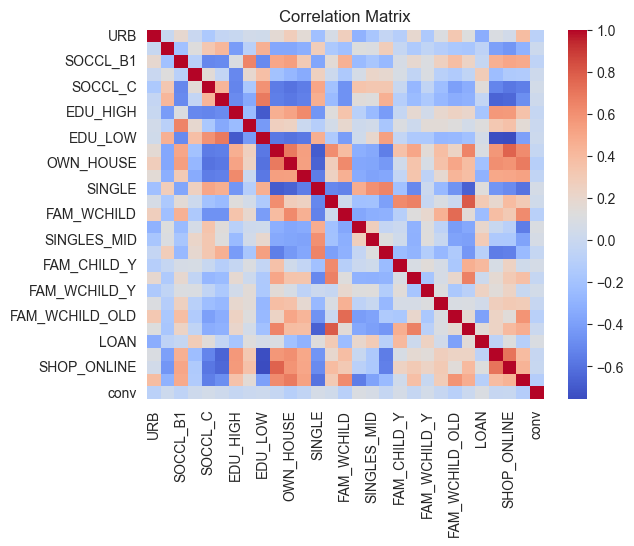

In [38]:
numeric_cols = df_tb.select_dtypes(include='number').columns
corr = df_tb[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 5 CLUSTERING

Using only converted customers (conv == 1), the code removes the conv flag, one-hot encodes remaining categorical fields, scales numeric features, and applies PCA to reduce dimensionality. It then plots cumulative explained variance to determine the optimal number of principal components, setting the stage for clustering in the lower-dimensional space.

In [39]:
df_sub = df_tb[df_tb["conv"]==1].copy()

In [40]:
df_sub = df_sub.drop(columns = ["conv"])

In [42]:
df_sub_clean = df_sub.dropna() 

In [43]:
categorical_cols = df_sub.select_dtypes(include='object').columns
df_sub_encoded = pd.get_dummies(df_sub_clean, columns=categorical_cols, drop_first=True)

In [44]:
X = df_sub_encoded.select_dtypes(include='number')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

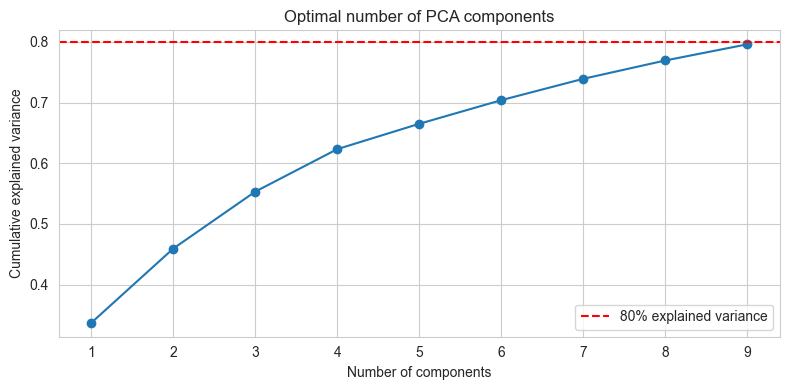

Optimal number of PCA components: 1


In [45]:
pca = PCA(n_components = 9)
X_pca = pca.fit_transform(X_scaled)

# Cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.80, color='r', linestyle='--', label='80% explained variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Optimal number of PCA components')
plt.legend()
plt.tight_layout()
plt.show()

# Select number of components where cum_var > desired threshold (e.g., 0.9)
n_components = np.argmax(cum_var >= 0.09) + 1
print(f"Optimal number of PCA components: {n_components}")

In [47]:
components = pca.components_
clustering_feature_cols = df_sub.columns.tolist()
n_top = 5
top_features = {}

for i, comp in enumerate(components[0:15]):
    indices = np.argsort(np.abs(comp))[::-1][:n_top]
    top_features[f'PC{i+1}'] = [(clustering_feature_cols[idx], comp[idx]) for idx in indices]

rows = []
for pc, feats in top_features.items():
    for feat, weight in feats:
        rows.append({'PC': pc, 'Feature': feat, 'Loading': weight})
        

In [48]:
df_pca_loadings = pd.DataFrame(rows)

In [49]:
df_pca_loadings

,PC,Feature,Loading
0,PC1,DINK,0.283016
1,PC1,OWN_HOUSE,0.272181
2,PC1,SHOP_ONLINE,0.257914
3,PC1,SINGLE,-0.255646
4,PC1,CAR,0.253581
5,PC2,CIT_HOUSEHOLD,0.366763
6,PC2,FAM,0.357688
7,PC2,FAM_CHILD_O,0.331113
8,PC2,EDU_LOW,0.320553
9,PC2,SINGLES_YOUNG,-0.276626


In [50]:
df_pca_loadings["AbsLoading"] = df_pca_loadings["Loading"].abs()

# Thresholds and labels
thresholds = {0.10: "≥10%", 0.20: "≥20%", 0.30: "≥30%"}

summary_dict = {"PC": sorted(df_pca_loadings["PC"].unique())}
for thr, label in thresholds.items():
    summary_dict[label] = []

for pc in summary_dict["PC"]:
    subset = df_pca_loadings[df_pca_loadings["PC"] == pc]
    for thr, label in thresholds.items():
        feats = (subset[subset["AbsLoading"] >= thr]
                 .sort_values("AbsLoading", ascending=False)["Feature"]
                 .tolist())
        summary_dict[label].append(",".join(feats))

summary_df = pd.DataFrame(summary_dict)

In [51]:
summary_df

,PC,≥10%,≥20%,≥30%
0,PC1,"DINK,OWN_HOUSE,SHOP_ONLINE,SINGLE,CAR","DINK,OWN_HOUSE,SHOP_ONLINE,SINGLE,CAR",
1,PC2,"CIT_HOUSEHOLD,FAM,FAM_CHILD_O,EDU_LOW,SINGLES_...","CIT_HOUSEHOLD,FAM,FAM_CHILD_O,EDU_LOW,SINGLES_...","CIT_HOUSEHOLD,FAM,FAM_CHILD_O,EDU_LOW"
2,PC3,"LOAN,FAM_CHILD_Y,URB,FAM_WCHILD_OLD,FAM","LOAN,FAM_CHILD_Y,URB,FAM_WCHILD_OLD,FAM","LOAN,FAM_CHILD_Y,URB,FAM_WCHILD_OLD"
3,PC4,"EDU_MID,SOCCL_B2,EDU_HIGH,SOCCL_B1,FAM_WCHILD_Y","EDU_MID,SOCCL_B2,EDU_HIGH,SOCCL_B1,FAM_WCHILD_Y","EDU_MID,SOCCL_B2,EDU_HIGH"
4,PC5,"FAM_WCHILD_Y,FAM_WCHILD,EDU_MID,FAM_WCHILD_MED...","FAM_WCHILD_Y,FAM_WCHILD,EDU_MID,FAM_WCHILD_MED...","FAM_WCHILD_Y,FAM_WCHILD,EDU_MID,FAM_WCHILD_MED"
5,PC6,"FAM_WCHILD_MED,INCOME_final,SINGLES_OLD,EDU_MI...","FAM_WCHILD_MED,INCOME_final,SINGLES_OLD,EDU_MI...","FAM_WCHILD_MED,INCOME_final,SINGLES_OLD"
6,PC7,"SINGLES_MID,FAM_WCHILD_MED,URB,SOCCL_B2,FAM_CH...","SINGLES_MID,FAM_WCHILD_MED,URB,SOCCL_B2,FAM_CH...","SINGLES_MID,FAM_WCHILD_MED,URB"
7,PC8,"SINGLES_OLD,SOCCL_B2,FAM_CHILD_Y,FAM_CHILD_O,I...","SINGLES_OLD,SOCCL_B2,FAM_CHILD_Y,FAM_CHILD_O,I...","SINGLES_OLD,SOCCL_B2,FAM_CHILD_Y"
8,PC9,"FAM_WCHILD_Y,URB,FAM_WCHILD_MED,INCOME_final,A...","FAM_WCHILD_Y,URB,FAM_WCHILD_MED,INCOME_final,A...","FAM_WCHILD_Y,URB,FAM_WCHILD_MED,INCOME_final"


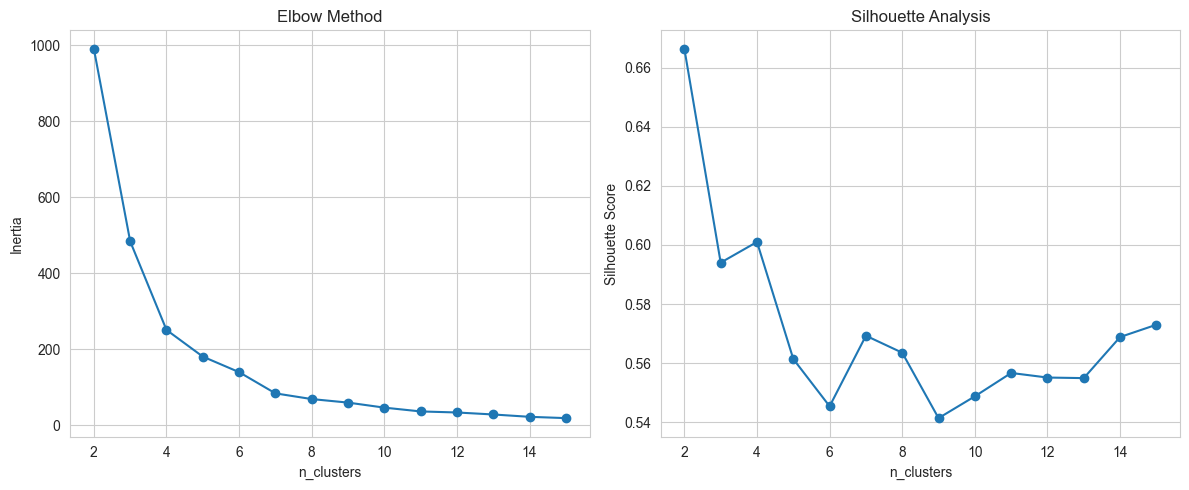

Optimal number of clusters by silhouette: 2


In [52]:
sil_scores = []
inertias = []
K = range(2, 16)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1)
    labels = kmeans.fit_predict(X_pca[:, :n_components])  # use reduced data
    sil = silhouette_score(X_pca[:, :n_components], labels)
    sil_scores.append(sil)
    inertias.append(kmeans.inertia_)
    

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# Optionally, print best k by silhouette
best_k = K[np.argmax(sil_scores)]
print(f"Optimal number of clusters by silhouette: {best_k}")


In [53]:
sil_matrix = np.zeros((15, 15)) 

for nc in range(2, 16):
    pca_cycle = PCA(n_components=nc)
    X_pc = pca_cycle.fit_transform(X_scaled)
    for k in range(2, 16):
        kmeans = KMeans(n_clusters=k, random_state=1)
        labels = kmeans.fit_predict(X_pc)
        sil = silhouette_score(X_pc, labels)
        sil_matrix[nc-1, k-1] = sil

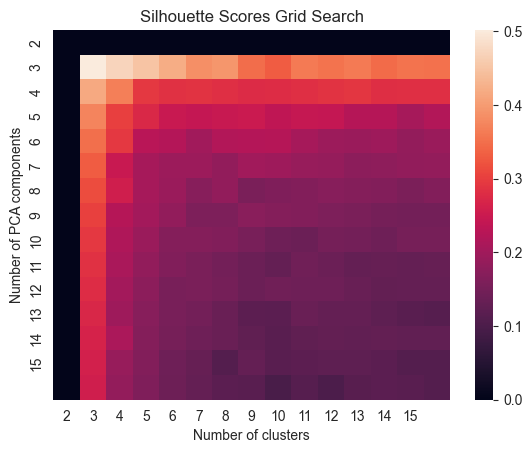

In [54]:
sns.heatmap(sil_matrix, xticklabels=range(2,16), yticklabels=range(2,16))
plt.xlabel('Number of clusters')
plt.ylabel('Number of PCA components')
plt.title('Silhouette Scores Grid Search')
plt.show()

In [55]:
kmeans_pca = KMeans(n_clusters=4, random_state=1)
labels_pca = kmeans_pca.fit_predict(X_pca)
score_pca = silhouette_score(X_pca, labels_pca)
print(f'Silhouette score with PCA: {score_pca:.3f}')

Silhouette score with PCA: 0.194


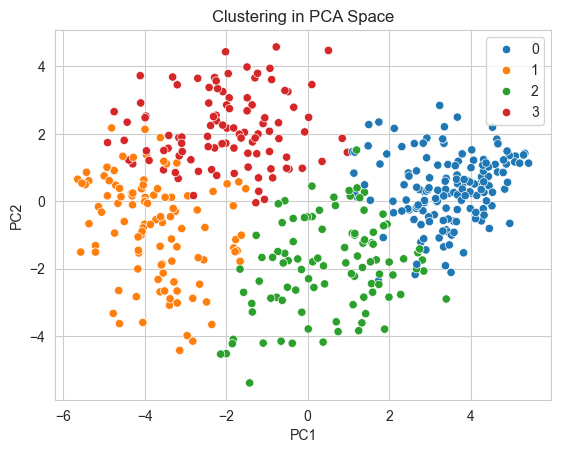

In [56]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_pca, palette='tab10')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Clustering in PCA Space')
plt.show()

In [58]:
pc_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]

df_pca = pd.DataFrame(X_pca, columns=pc_columns)
df_pca['cluster'] = labels_pca.astype(str)  # Convert to string for color-coding

In [59]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,cluster
0,3.195165,1.068259,-0.076336,-1.347991,-1.338159,0.285699,0.003825,0.715907,1.403638,0
1,4.878790,1.101507,-0.633620,-1.618504,-0.486108,-0.080980,-0.901616,0.010248,-0.298130,0
2,3.828669,-1.533097,-2.617079,0.547690,0.185831,1.704874,-1.838731,0.224569,-0.512769,0
3,4.007439,0.226030,1.133480,1.473137,-0.186729,-0.216980,-0.837386,0.031095,0.765263,0
4,-2.119389,1.689285,1.186758,0.149084,1.935284,-0.447876,-0.233791,-1.982445,2.039794,3
...,...,...,...,...,...,...,...,...,...,...
482,1.212073,0.392497,-0.076612,0.808465,-1.359983,-1.365676,0.869515,0.362987,-0.675867,2
483,-4.280664,1.299539,0.186096,-0.554171,1.611597,0.735984,-0.472147,-0.068580,0.239648,1
484,1.850659,-0.386226,2.234053,2.314147,1.654540,0.748453,-0.886293,0.100906,-0.680226,2
485,4.672648,1.702448,0.382852,-0.984798,-1.951501,0.316003,-0.672502,-0.624796,1.217259,0


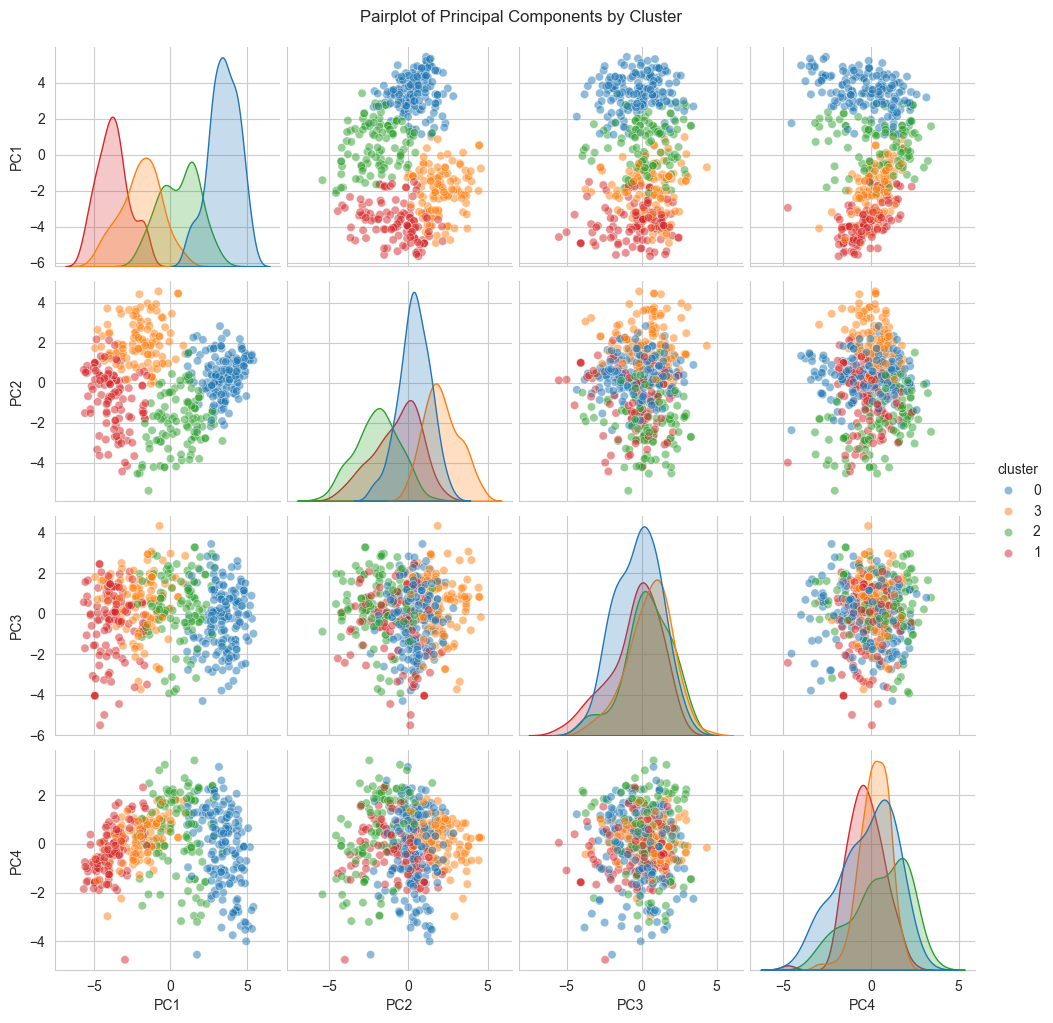

In [60]:
sns.pairplot(
    df_pca, 
    vars=pc_columns[0:4],         
    hue='cluster',          
    palette='tab10',         
    plot_kws={'alpha': 0.5}
)
plt.suptitle('Pairplot of Principal Components by Cluster', y=1.02)
plt.show()

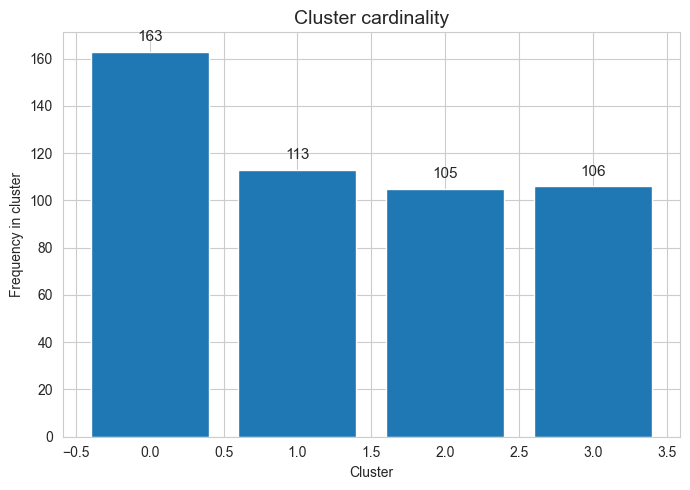

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

labels = kmeans_pca.labels_          # cluster ID per record
X       = X_pca                            # PCA-transformed data (n × p)

freq_by_cluster = pd.Series(labels).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(freq_by_cluster.index, freq_by_cluster.values)

# nice thousands format on y-axis
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
# text labels above bars
for idx, val in enumerate(freq_by_cluster.values):
    ax.text(idx, val + freq_by_cluster.max() * 0.02,
            f"{val:,.0f}", ha="center", va="bottom", fontsize=11)

ax.set_title("Cluster cardinality", fontsize=14)
ax.set_xlabel("Cluster")
ax.set_ylabel("Frequency in cluster")
plt.tight_layout()
plt.show()

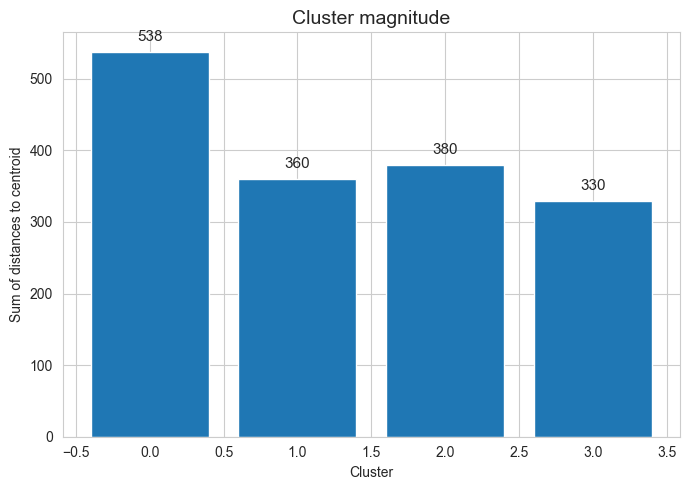

In [62]:
centroids = kmeans_pca.cluster_centers_
distances = np.linalg.norm(X - centroids[labels], axis=1)          # n × 1
magnitude = pd.Series(distances).groupby(labels).sum().sort_index()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(magnitude.index, magnitude.values)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
for idx, val in enumerate(magnitude.values):
    ax.text(idx, val + magnitude.max() * 0.02,
            f"{val:,.0f}", ha="center", va="bottom", fontsize=11)

ax.set_title("Cluster magnitude", fontsize=14)
ax.set_xlabel("Cluster")
ax.set_ylabel("Sum of distances to centroid")
plt.tight_layout()
plt.show()

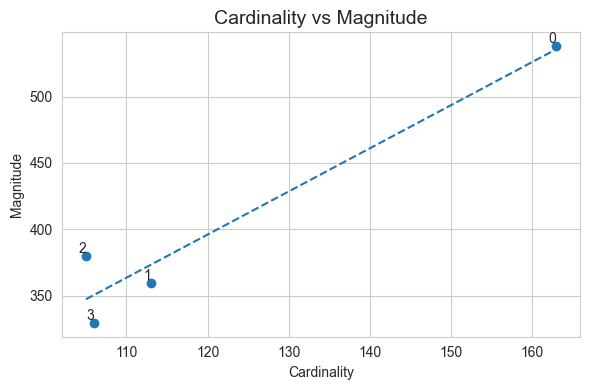

In [64]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(freq_by_cluster.values, magnitude.values)

# add least-squares trend line
coef = np.polyfit(freq_by_cluster.values, magnitude.values, 1)
xs   = np.linspace(freq_by_cluster.min(), freq_by_cluster.max(), 100)
ax.plot(xs, np.poly1d(coef)(xs), linestyle="--")

# number labels next to points
for cl, x, y in zip(freq_by_cluster.index,
                    freq_by_cluster.values,
                    magnitude.values):
    ax.text(x, y, str(cl), fontsize=10, ha="right", va="bottom")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_title("Cardinality vs Magnitude", fontsize=14)
ax.set_xlabel("Cardinality")
ax.set_ylabel("Magnitude")
plt.tight_layout()
plt.show()

Conclusion: There are no outliers and clusters are valid.

In [66]:
joblib.dump(scaler,  'scaler.pkl')
joblib.dump(pca,     'pca.pkl')
joblib.dump(kmeans_pca,  'kmeans_pca.pkl')

['kmeans_pca.pkl']

In [67]:
feat_cols = df_sub.columns
X_tb = df_tb.copy()          

X_tb = X_tb.reindex(columns=feat_cols)

# load objects -----------------------------------------------------------
scaler  = joblib.load('scaler.pkl')
pca     = joblib.load('pca.pkl')
kmeans_pca_model  = joblib.load('kmeans_pca.pkl')

# 1. feature matrix ------------------------------------------------------
X_tb = df_tb[feat_cols].copy()

# 2. identical preprocessing --------------------------------------------
X_scaled = scaler.transform(X_tb)         

# 3. project to PC space -------------------------------------------------
X_pc     = pca.transform(X_scaled)         

# 4. assign clusters -----------------------------------------------------
df_tb['cluster'] = kmeans_pca_model.predict(X_pc)

df_tb['cluster'].value_counts()

cluster
0    1540
2     749
3     709
1     656
Name: count, dtype: int64

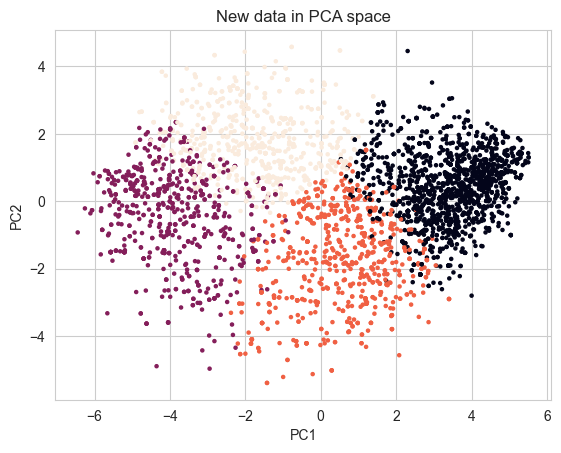

In [68]:
plt.scatter(X_pc[:,0], X_pc[:,1], c=df_tb['cluster'], s=5)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('New data in PCA space')
plt.show()

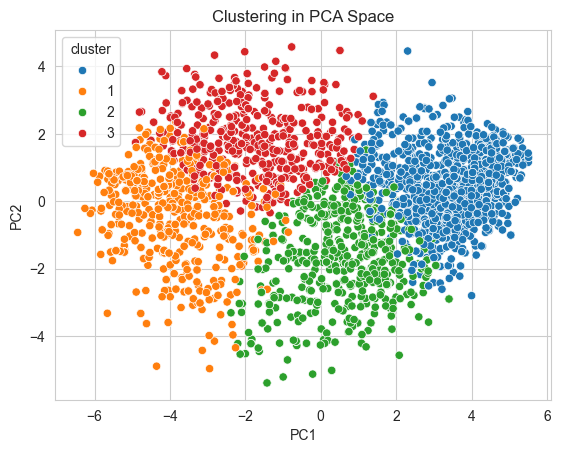

In [69]:
sns.scatterplot(x=X_pc[:,0], y=X_pc[:,1], hue=df_tb['cluster'], palette='tab10')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Clustering in PCA Space')
plt.show()

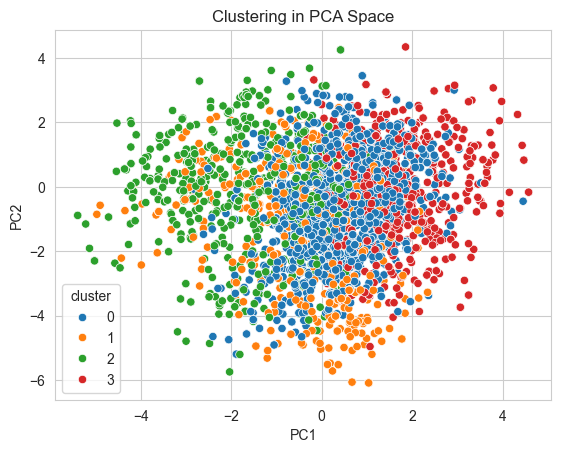

In [70]:
sns.scatterplot(x=X_pc[:,1], y=X_pc[:,2], hue=df_tb['cluster'], palette='tab10')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Clustering in PCA Space')
plt.show()

In [72]:
# 1. How many centroids did the stored model have?
print("k =", kmeans_pca.n_clusters)                

# 2. Which labels occurred in the TRAINING run?
train_labels = np.unique(kmeans_pca.labels_)
print("labels seen during fit:", train_labels) 

# 3. Which labels turn up in the NEW data?
new_labels = np.unique(kmeans_pca_model.predict(X_pc))
print("labels seen in df_tb:", new_labels) 


k = 4
labels seen during fit: [0 1 2 3]
labels seen in df_tb: [0 1 2 3]


In [74]:
pivot_conv_clusters = (df_tb
                       .groupby('conv')['cluster']          
                       .unique()                           
                       .apply(lambda arr: sorted(arr))     
                       .reset_index(name='clusters'))      

pivot_conv_clusters


,conv,clusters
0,0,"[0, 1, 2, 3]"
1,1,"[0, 1, 2, 3]"


In [75]:
conv_rate_by_cluster = (
    df_tb
      .groupby('cluster')                       
      .agg(
          conv_rate=('conv', 'mean'),           
          n_rows   =('conv', 'size')            
      )
      .reset_index()                           
)

conv_rate_by_cluster


,cluster,conv_rate,n_rows
0,0,0.105844,1540
1,1,0.172256,656
2,2,0.140187,749
3,3,0.149506,709


# 6 AUTO DATA CLUSTERING

Here, the analysis shifts to brand-level clustering: numeric features are aggregated by brand (mean, std, min, max), categorical distributions (e.g., fuel type) are encoded as proportions, and brands are clustered via KMeans. The script evaluates optimal cluster numbers, assigns brand clusters, and examines conversion rates by brand cluster to reveal brand-level patterns.

In [76]:
columns_to_keep_cars = ['conv',
                        "brand",
                        'weight_car', 'mileage_car', 'power_car', 'fuel_car',
                        #'chassis', 'drive', 'turbo', 'transmission'                
       ]


In [77]:
df_cars = df[(df["affinity_name"]=="T&B")][columns_to_keep_cars].copy()

In [78]:
df_cars.describe()

,conv,weight_car,mileage_car,power_car
count,3694.000000,3593.000000,3593.000000,3593.000000
mean,0.134001,1052.744766,14.582569,68.380219
std,0.340700,180.216638,1.064085,21.296315
min,0.000000,695.000000,10.000000,33.000000
25%,0.000000,955.962963,14.444444,55.200000
50%,0.000000,1005.562500,15.000000,62.045455
75%,0.000000,1080.200000,15.000000,68.266667
max,1.000000,2320.000000,20.000000,261.000000


In [79]:
print(df_cars.isna().sum())

conv             0
brand            0
weight_car     101
mileage_car    101
power_car      101
fuel_car       101
dtype: int64


In [80]:
df_cars.dropna(axis=0, how='any', inplace=True)

In [81]:
print(df_cars.isna().sum())

conv           0
brand          0
weight_car     0
mileage_car    0
power_car      0
fuel_car       0
dtype: int64


In [82]:
df_cars["brand"].value_counts()

brand
VOLKSWAGEN       466
OPEL             343
PEUGEOT          308
RENAULT          265
FORD             251
TOYOTA           231
CITROEN          159
BMW              153
FIAT             136
MERCEDES-BENZ    128
SEAT             118
VOLVO            113
AUDI             113
SUZUKI           112
HYUNDAI          107
KIA              104
NISSAN            93
MAZDA             75
SKODA             63
MITSUBISHI        48
DAIHATSU          36
HONDA             34
CHEVROLET         30
MINI              21
ALFA ROMEO        19
DAEWOO            19
SUBARU            16
SMART             11
LAND ROVER        11
LEXUS              5
ROVER              5
Name: count, dtype: int64

In [84]:
num_agg = (
    df_cars
      .groupby('brand')[['weight_car','mileage_car','power_car']]
      .agg(['mean','std','min','max'])
)
# flatten the MultiIndex
num_agg.columns = ['_'.join(col) for col in num_agg.columns]

cat_cols = ['fuel_car']
cat_dfs = []
for col in cat_cols:
    dummies = pd.get_dummies(df_cars[[ 'brand', col ]].set_index('brand')[col], prefix=col)
    prop = (
        dummies
          .groupby(level=0)
          .sum()
          .div( dummies.groupby(level=0).sum().sum(axis=1), axis=0 )
    )
    cat_dfs.append(prop)
    
cat_agg = pd.concat(cat_dfs, axis=1)

brand_features = pd.concat([num_agg, cat_agg], axis=1).fillna(0)


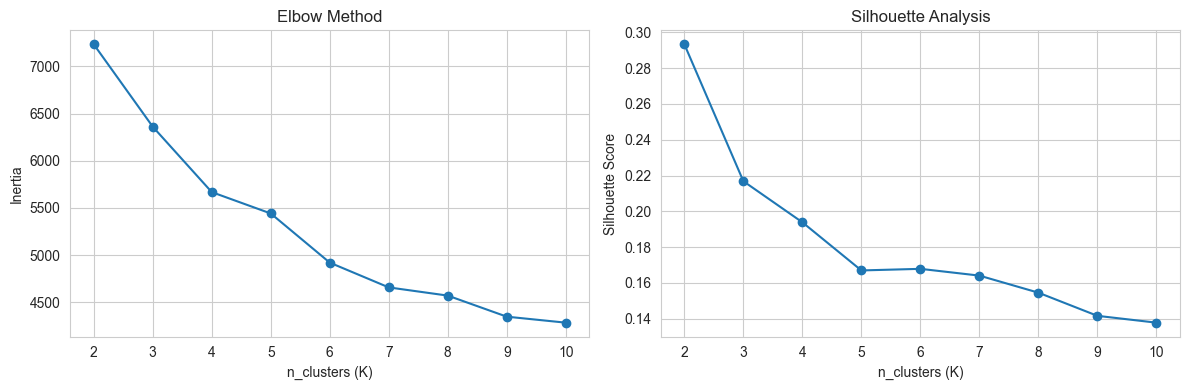

In [85]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ks = range(2, 11)
inertias = []
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=1)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Elbow plot (inertia vs K)
axes[0].plot(ks, inertias, '-o')
axes[0].set_xlabel('n_clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')

# Silhouette plot (score vs K)
axes[1].plot(ks, sil_scores, '-o')
axes[1].set_xlabel('n_clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')

plt.tight_layout()
plt.show()


In [86]:
brand_features

,weight_car_mean,weight_car_std,weight_car_min,weight_car_max,mileage_car_mean,mileage_car_std,mileage_car_min,mileage_car_max,power_car_mean,power_car_std,power_car_min,power_car_max,fuel_car_DIESEL,fuel_car_GASOLINE,fuel_car_HYBR/GAS,fuel_car_LPG
brand,,,,,,,,,,,,,,,,
ALFA ROMEO,1211.250000,42.143109,1125.0,1360.0,11.250000,1.020621,10.0,15.0,88.250000,12.116907,59.0,129.0,0.894737,0.105263,0.000000,0.000000
AUDI,1335.000000,11.970947,1295.0,1440.0,15.000000,0.000000,15.0,15.0,99.166667,3.169094,74.0,110.0,1.000000,0.000000,0.000000,0.000000
BMW,1450.555556,77.839757,1225.0,2320.0,15.000000,0.811107,10.0,20.0,133.222222,13.812074,77.0,261.0,0.019608,0.980392,0.000000,0.000000
CHEVROLET,828.000000,45.767780,750.0,1041.0,15.000000,0.000000,15.0,15.0,43.750000,3.698788,38.0,61.0,0.000000,1.000000,0.000000,0.000000
CITROEN,1023.266667,51.787231,805.0,1395.0,15.666667,0.523700,15.0,20.0,61.600000,4.905177,44.0,84.0,0.025157,0.974843,0.000000,0.000000
DAEWOO,775.000000,0.000000,775.0,775.0,10.000000,0.000000,10.0,10.0,46.000000,0.000000,46.0,46.0,0.000000,1.000000,0.000000,0.000000
DAIHATSU,695.000000,0.000000,695.0,695.0,17.500000,0.597614,15.0,20.0,43.000000,0.000000,43.0,43.0,0.000000,1.000000,0.000000,0.000000
FIAT,917.500000,40.812353,710.0,1120.0,13.500000,0.871355,10.0,20.0,55.200000,3.317295,40.0,74.0,0.022059,0.977941,0.000000,0.000000
FORD,985.500000,23.150724,862.0,1216.0,15.000000,0.447214,10.0,20.0,53.750000,3.108858,44.0,92.0,0.011952,0.988048,0.000000,0.000000


In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
X = scaler.fit_transform(brand_features)

sil_scores = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=1).fit(X)
    sil = silhouette_score(X, km.labels_)
    sil_scores.append((k, sil))

In [89]:
sil_scores

[(2, np.float64(0.30585031354999237)),
 (3, np.float64(0.3049000552432773)),
 (4, np.float64(0.22373735328542244)),
 (5, np.float64(0.26995023782265465)),
 (6, np.float64(0.2838690657430274)),
 (7, np.float64(0.31141797534577587))]

In [90]:
kmeans = KMeans(n_clusters=5, random_state=1).fit(X)
brand_features['cluster_kmeans'] = kmeans.labels_

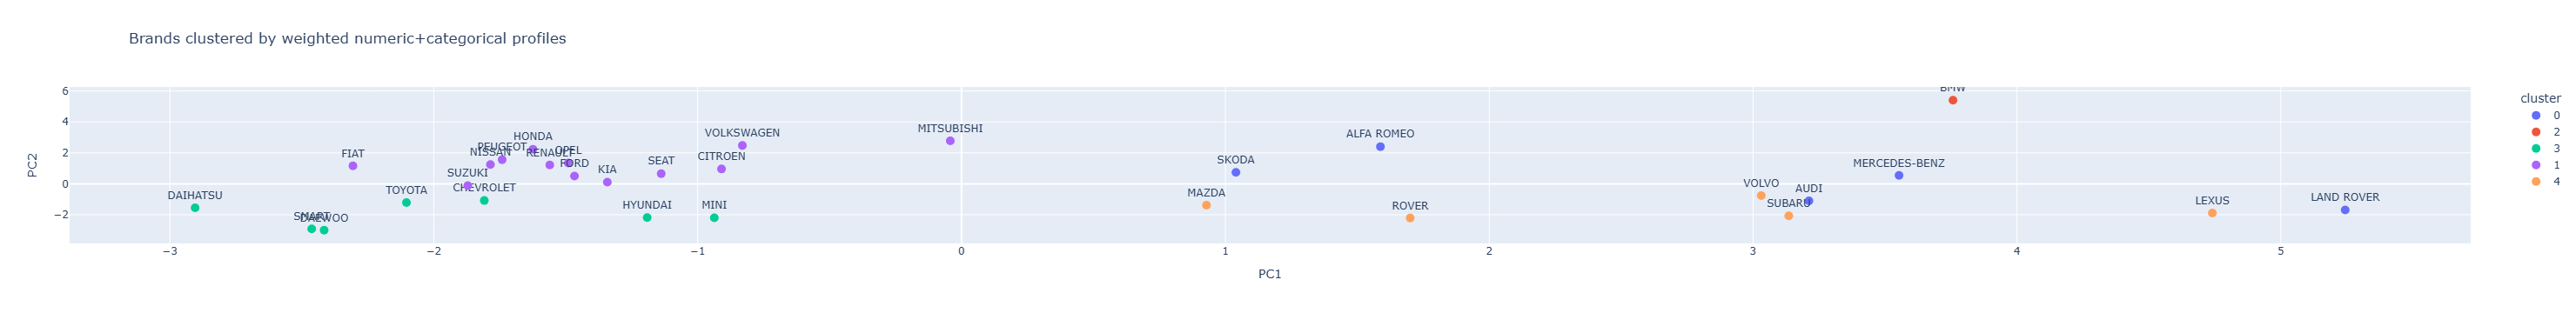

In [92]:
from sklearn.decomposition import PCA
import plotly.express as px

# reduce to 2D for viz
pca = PCA(n_components=2, random_state=1)
coords = pca.fit_transform(scaler.fit_transform(brand_features.drop(columns=['cluster_kmeans'])))
viz_df = pd.DataFrame(coords, columns=['PC1','PC2'], index=brand_features.index)
viz_df['cluster'] = brand_features['cluster_kmeans'].astype(str)

fig = px.scatter(
    viz_df.reset_index(),
    x='PC1', y='PC2', text='brand',
    color='cluster',
    title='Brands clustered by weighted numeric+categorical profiles'
)
fig.update_traces(textposition='top center', marker=dict(size=10))
fig.show()


In [95]:
# if you want each car to know its brand‐cluster:
df_cars = df_cars.merge(
    brand_features[['cluster_kmeans']],
    left_on='brand', right_index=True
)

In [96]:
df_cars.head()

,conv,brand,weight_car,mileage_car,power_car,fuel_car,cluster_kmeans
787,0,ALFA ROMEO,1211.250000,11.250000,88.250000,DIESEL,0
873,0,MERCEDES-BENZ,1365.375000,15.000000,99.500000,DIESEL,0
952,1,RENAULT,839.000000,15.000000,55.000000,GASOLINE,1
953,0,RENAULT,1001.909091,14.750000,62.045455,GASOLINE,1
954,0,CITROEN,1023.266667,15.666667,61.600000,GASOLINE,1


In [97]:
conv_rate_by_cluster_cars = (
    df_cars
      .groupby('cluster_kmeans')                       # one row per cluster
      .agg(
          conv_rate=('conv', 'mean'),           # average conversion rate
          n_rows   =('conv', 'size')            # number of rows / customers
      )
      .reset_index()                            # tidy two-column index
)

conv_rate_by_cluster_cars

,cluster_kmeans,conv_rate,n_rows
0,0,0.128743,334
1,1,0.146081,2437
2,2,0.137255,153
3,3,0.105495,455
4,4,0.098131,214


In [98]:
conv_rate_pivot = pd.pivot_table(
    df_cars,
    values='conv',
    index='brand',
    columns='cluster_kmeans',
    aggfunc='mean',
    fill_value=0
)

In [99]:
conv_rate_pivot

cluster_kmeans,0,1,2,3,4
brand,,,,,
ALFA ROMEO,0.210526,0.000000,0.000000,0.000000,0.000000
AUDI,0.150442,0.000000,0.000000,0.000000,0.000000
BMW,0.000000,0.000000,0.137255,0.000000,0.000000
CHEVROLET,0.000000,0.000000,0.000000,0.266667,0.000000
CITROEN,0.000000,0.169811,0.000000,0.000000,0.000000
DAEWOO,0.000000,0.000000,0.000000,0.157895,0.000000
DAIHATSU,0.000000,0.000000,0.000000,0.138889,0.000000
FIAT,0.000000,0.147059,0.000000,0.000000,0.000000
FORD,0.000000,0.111554,0.000000,0.000000,0.000000


In [100]:
brand_cluster = (
    df_cars[['brand','cluster_kmeans']]
      .drop_duplicates()               # one row per brand
      #.set_index('brand')              # index=brand, column=cluster_kmeans
)

In [101]:
brand_cluster = (
    df_cars                    
      .groupby(['brand', 'cluster_kmeans'])   
      .size()                                   
      .reset_index(name='n_rows')              
      .sort_values(['cluster_kmeans', 'n_rows'],   
                   ascending=[True, False])        
      .reset_index(drop=True)                   
)

brand_cluster

,brand,cluster_kmeans,n_rows
0,MERCEDES-BENZ,0,128
1,AUDI,0,113
2,SKODA,0,63
3,ALFA ROMEO,0,19
4,LAND ROVER,0,11
5,VOLKSWAGEN,1,466
6,OPEL,1,343
7,PEUGEOT,1,308
8,RENAULT,1,265
9,FORD,1,251


In [102]:
pivot = (
    brand_cluster
      .groupby('cluster_kmeans')
      .agg(
          brands = ('brand',  lambda x: ', '.join(sorted(x))),  # list brands
          n_rows = ('n_rows', 'sum')                           # total obs
      )
      .reset_index()                      # keep cluster as a column
      .sort_values('cluster_kmeans')      # ensure ascending cluster order
)

pivot

,cluster_kmeans,brands,n_rows
0,0,"ALFA ROMEO, AUDI, LAND ROVER, MERCEDES-BENZ, S...",334
1,1,"CITROEN, FIAT, FORD, HONDA, KIA, MITSUBISHI, N...",2437
2,2,BMW,153
3,3,"CHEVROLET, DAEWOO, DAIHATSU, HYUNDAI, MINI, SM...",455
4,4,"LEXUS, MAZDA, ROVER, SUBARU, VOLVO",214


In [103]:
assert not brand_cluster["brand"].duplicated().any(), "Some brands had multiple clusters!"

In [104]:
df_tb.head()

,URB,INCOME_final,SOCCL_B1,SOCCL_B2,SOCCL_C,SOCCL_D,EDU_HIGH,EDU_MID,EDU_LOW,DINK,...,FAM_WCHILD_Y,FAM_WCHILD_MED,FAM_WCHILD_OLD,CIT_HOUSEHOLD,LOAN,SAVINGS,SHOP_ONLINE,CAR,conv,cluster
787,5.0,2.0,4.0,2.0,1.0,2.0,3.0,4.0,2.0,6.0,...,1.0,3.0,4.0,5.0,1.0,5.0,6.0,5.0,0,0
873,4.0,6.0,3.0,3.0,1.0,1.0,1.0,5.0,2.0,3.0,...,1.0,2.0,4.0,4.0,2.0,5.0,3.0,3.0,0,2
952,7.0,2.0,3.0,2.0,2.0,1.0,4.0,3.0,2.0,5.0,...,1.0,1.0,3.0,5.0,1.0,4.0,6.0,5.0,1,0
953,7.0,2.0,3.0,2.0,2.0,1.0,4.0,3.0,2.0,5.0,...,1.0,1.0,3.0,5.0,1.0,4.0,6.0,5.0,0,0
954,7.0,2.0,3.0,2.0,2.0,1.0,4.0,3.0,2.0,5.0,...,1.0,1.0,3.0,5.0,1.0,4.0,6.0,5.0,0,0


# 7 CLUSTERING OVERVIEW

After clustering, the script evaluates cluster validity via inertia (elbow method) and silhouette scores, visualizes the silhouette grid over combinations of PCA components and cluster counts, and inspects cluster distribution and summary statistics (mean profiles per cluster). Bar charts and scatterplots help interpret cluster sizes and separations.

In [105]:
cluster_counts = (
    df_tb
    .groupby("cluster")      # split the DataFrame by cluster label
    .size()                  # count rows in each group
    .reset_index(name="n")   # convert to DataFrame; call the new column "n"
)

print(cluster_counts)

   cluster     n
0        0  1540
1        1   656
2        2   749
3        3   709


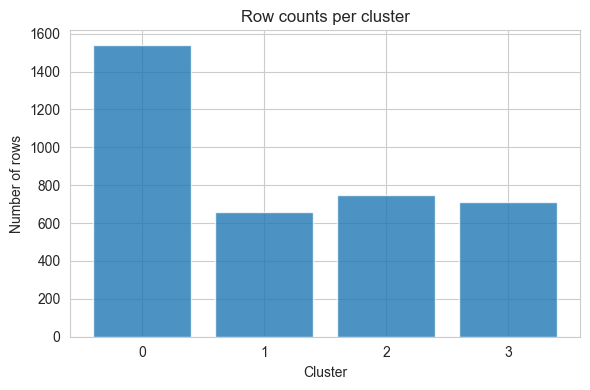

In [106]:
import matplotlib.pyplot as plt
import pandas as pd

try:
    cluster_counts
except NameError:
    cluster_counts = (
        df_tb.groupby("cluster")
             .size()
             .reset_index(name="n")
    )

# Build the bar chart
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(
    cluster_counts["cluster"].astype(str),  # x‑axis labels
    cluster_counts["n"],                    # bar heights
    alpha=0.8
)

ax.set_xlabel("Cluster")
ax.set_ylabel("Number of rows")
ax.set_title("Row counts per cluster")

plt.tight_layout()
plt.show()


In [107]:
cluster_means = (
    df_tb
    .groupby("cluster")          # partition rows by the cluster label
    .mean(numeric_only=True)     # take the arithmetic mean of every numeric column
    .reset_index()               
)

print(cluster_means)

   cluster       URB  INCOME_final  SOCCL_B1  SOCCL_B2   SOCCL_C   SOCCL_D  \
0        0  4.357792      2.674675  2.978571  2.136364  1.278571  1.150649   
1        1  3.111280      3.978659  1.347561  2.359756  2.955793  2.905488   
2        2  2.861148      2.676903  2.919893  2.859813  1.526035  1.190921   
3        3  3.702398      3.716502  1.650212  3.296192  2.468265  2.320169   

   EDU_HIGH   EDU_MID   EDU_LOW  ...  FAM_CHILD_O  FAM_WCHILD_Y  \
0  3.131818  3.289610  1.860390  ...     3.262987      1.444156   
1  1.335366  2.579268  4.155488  ...     1.862805      1.338415   
2  2.552737  3.735648  1.897196  ...     2.197597      1.997330   
3  1.307475  2.377997  4.441467  ...     3.012694      1.352609   

   FAM_WCHILD_MED  FAM_WCHILD_OLD  CIT_HOUSEHOLD      LOAN   SAVINGS  \
0        2.327922        3.307792       4.619481  2.557143  5.204545   
1        1.667683        1.967988       2.632622  2.527439  2.966463   
2        2.094793        2.523364       3.285714  3.51134

In [108]:
full_table = cluster_means.to_string(index=False, max_rows=None, max_cols=None)
print(full_table)

 cluster      URB  INCOME_final  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  EDU_HIGH  EDU_MID  EDU_LOW     DINK  OWN_HOUSE  AVG_HOUSE   SINGLE      FAM  FAM_WCHILD  SINGLES_YOUNG  SINGLES_MID  SINGLES_OLD  FAM_CHILD_Y  FAM_CHILD_O  FAM_WCHILD_Y  FAM_WCHILD_MED  FAM_WCHILD_OLD  CIT_HOUSEHOLD     LOAN  SAVINGS  SHOP_ONLINE      CAR     conv
       0 4.357792      2.674675  2.978571  2.136364 1.278571 1.150649  3.131818 3.289610 1.860390 4.796104   4.359091   8.479221 2.354545 4.246753    4.076623       1.275325     1.639610     1.739610     3.049351     3.262987      1.444156        2.327922        3.307792       4.619481 2.557143 5.204545     5.233117 4.824675 0.105844
       1 3.111280      3.978659  1.347561  2.359756 2.955793 2.905488  1.335366 2.579268 4.155488 1.532012   1.504573   3.858232 4.868902 2.876524    2.542683       2.492378     2.716463     3.157012     2.471037     1.862805      1.338415        1.667683        1.967988       2.632622 2.527439 2.966463     2.077744 2.054878 0

In [109]:
df_full = df.merge(
    brand_cluster.rename(columns={'cluster_kmeans':'car_brand_cluster'}),
    on='brand',
    how='left'
)


In [110]:
df_full.head()

,affinity_name,status_report,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,date_offer,date_request,...,coverage_type,age,age_band,urb_norm,buildmonth_num,build_date,car_age,INCOME_final,car_brand_cluster,n_rows
0,other,Policycreated,1003,10002.0,10003,6921,1983-08-01,MAZDA,2018-10-11,2018-10-11,...,2. Liability + limited casco,36.0,35–44,4-Mid,06,2009-06-01,10.0,2.0,4.0,75.0
1,Insuro,Requestwithdrawn,1000,10000.0,10000,2132,1985-01-01,HYUNDAI,2018-10-11,2018-10-11,...,1. Only liability insurance,34.0,25–34,3-Mid-to-High,06,2016-06-01,3.0,2.0,3.0,107.0
2,other,Tailoredofferwithdrawn,1001,NaN,10001,6027,1987-04-01,AUDI,2018-10-11,NaT,...,,32.0,25–34,7-VeryLow,06,2015-06-01,4.0,2.0,0.0,113.0
3,other,Incompleterequest,1002,NaN,10002,3824,1972-11-01,VOLKSWAGEN,2018-10-11,NaT,...,3. Liability + full casco,47.0,45–54,2-High,04,2016-04-01,3.0,2.0,1.0,466.0
4,other,Policycreated,1004,10003.0,10004,8266,1990-04-01,VOLVO,2018-10-12,2018-10-12,...,1. Only liability insurance,29.0,25–34,4-Mid,01,2003-01-01,16.0,3.0,4.0,113.0


In [111]:
pd.pivot_table(
    df_full,
    values='conv',
    #index='brand',
    columns='car_brand_cluster',
    aggfunc='mean',
    fill_value=0
)

car_brand_cluster,0.0,1.0,2.0,3.0,4.0
conv,0.129291,0.196244,0.167421,0.188646,0.15109


# 8 PREDICTIVE MODELLING

Building on the clustered data, this section defines a supervised learning pipeline to predict conv. It constructs preprocessing steps (median imputation, scaling, one-hot encoding), integrates SMOTE for class imbalance, and uses RandomizedSearchCV to tune classifiers (e.g., logistic regression). It reports performance metrics (accuracy, precision, recall, F1, ROC AUC) and visualizes confusion matrices and ROC curves.

In [113]:
extra_cols = [c for c in df_tb.columns if c not in df_full.columns]

df_tb_subset = df_tb[extra_cols]

df_merged = df_full.join(df_tb_subset, how='inner')


In [114]:
print(df_merged.shape)

(3626, 91)


In [115]:
print(df_merged.head())

                  affinity_name        status_report  offer_number  \
787                      Insuro        Policycreated          1798   
873  Seguros International Ltd.  Calculatenewpremium          1883   
952  Seguros International Ltd.    Incompleterequest          1962   
953                       other  Calculatenewpremium          1963   
954  Seguros International Ltd.    Incompleterequest          1964   

     policy_number  zipcode_link  zip4 birth_date    brand date_offer  \
787        10255.0         10524  1521 1990-07-01  PEUGEOT 2019-01-21   
873            NaN         10577  5071 1957-10-01     OPEL 2019-01-31   
952            NaN         10614  2565 1980-01-01  CITROEN 2019-02-11   
953            NaN         10615  2627 1965-06-01  HYUNDAI 2019-02-11   
954            NaN         10616  2804 1953-07-01     OPEL 2019-02-11   

    date_request  ...   age  age_band       urb_norm buildmonth_num  \
787   2019-01-21  ...  29.0     25–34   5-Mid-to-Low             01  

In [116]:
print(df_merged.isna().sum())

affinity_name           0
status_report           0
offer_number            0
policy_number        2750
zipcode_link            0
                     ... 
car_age                 0
INCOME_final            0
car_brand_cluster     120
n_rows                120
cluster                 0
Length: 91, dtype: int64


In [117]:
cols = [
    "affinity_name",
    "premium",
    "buildyear_car",
    "brand",
    "PROVINCE",
    "car_brand_cluster",
    "cluster",
    "coverage_type",
    "age",
    "conv"
]

In [118]:
df_model = df_merged[df_merged["affinity_name"]=="T&B"][cols]

In [119]:
df_model["affinity_name"].value_counts()

affinity_name
T&B    2027
Name: count, dtype: int64

In [120]:
df_model.drop(columns="affinity_name").head()

,premium,buildyear_car,brand,PROVINCE,car_brand_cluster,cluster,coverage_type,age,conv
1109,619.73,2011.0,NISSAN,South Holland,1.0,0,3. Liability + full casco,72.0,1
1641,265.32,2003.0,OPEL,Gelderland,1.0,1,1. Only liability insurance,41.0,0
1670,1110.72,2008.0,SUZUKI,Overijssel,1.0,3,2. Liability + limited casco,20.0,0
1684,543.24,1999.0,VOLKSWAGEN,North Holland,1.0,3,1. Only liability insurance,58.0,1
1709,503.16,2005.0,CITROEN,Gelderland,1.0,1,2. Liability + limited casco,24.0,0


In [121]:
df_model = df_model.dropna()

In [122]:
df_model.columns

Index(['affinity_name', 'premium', 'buildyear_car', 'brand', 'PROVINCE',
       'car_brand_cluster', 'cluster', 'coverage_type', 'age', 'conv'],
      dtype='object')

In [123]:
print(df_model.shape)

(1831, 10)


In [125]:
print(df_model.head())

     affinity_name  premium  buildyear_car       brand       PROVINCE  \
1109           T&B   619.73         2011.0      NISSAN  South Holland   
1641           T&B   265.32         2003.0        OPEL     Gelderland   
1670           T&B  1110.72         2008.0      SUZUKI     Overijssel   
1684           T&B   543.24         1999.0  VOLKSWAGEN  North Holland   
1709           T&B   503.16         2005.0     CITROEN     Gelderland   

      car_brand_cluster  cluster                 coverage_type   age  conv  
1109                1.0        0     3. Liability + full casco  72.0     1  
1641                1.0        1   1. Only liability insurance  41.0     0  
1670                1.0        3  2. Liability + limited casco  20.0     0  
1684                1.0        3   1. Only liability insurance  58.0     1  
1709                1.0        1  2. Liability + limited casco  24.0     0  


In [126]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

# For oversampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Classifiers to try
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [127]:
print("Shape of data:", df_model.shape)
print(df_model['conv'].value_counts(normalize=True))  # Check class balance

Shape of data: (1831, 10)
conv
0    0.89077
1    0.10923
Name: proportion, dtype: float64


In [128]:
y = df_model['conv']
X = df_model.drop(columns=['conv'])

In [130]:
# Identify feature types
numeric_features = ['premium', 'buildyear_car', 'age']
categorical_features = ['car_brand_cluster', 'cluster', 'coverage_type', 'PROVINCE']

In [131]:
# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1
)

In [132]:
X_train.head()

,affinity_name,premium,buildyear_car,brand,PROVINCE,car_brand_cluster,cluster,coverage_type,age
8639,T&B,318.96,2005.0,VOLKSWAGEN,Gelderland,1.0,0,2. Liability + limited casco,51.0
6653,T&B,979.80,2004.0,SUZUKI,South Holland,1.0,1,2. Liability + limited casco,47.0
4405,T&B,344.28,2013.0,PEUGEOT,Gelderland,1.0,0,3. Liability + full casco,64.0
8999,T&B,464.88,2003.0,FIAT,Limburg,1.0,0,1. Only liability insurance,39.0
7967,T&B,885.60,2006.0,OPEL,South Holland,1.0,2,1. Only liability insurance,34.0


In [133]:
# Define oversampling + model pipeline
base_pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=1)),
    ('clf', LogisticRegression(solver='liblinear', random_state=1))  # placeholder
])

In [134]:
# Hyperparameter grids for different classifiers
guide_params = {
    'LogisticRegression': {
        'clf': [LogisticRegression(random_state=1)],
        'clf__solver': ['lbfgs', 'sag', 'saga'],
        'clf__class_weight': ['balanced'],
        'clf__fit_intercept': [False],
        'clf__C': np.logspace(-3, 0, 3, 7, 10),
        'clf__penalty': [None,'l2']
    }
}

In [135]:
# Search over models and hyperparameters
results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for model_name, param_grid in guide_params.items():
    print(f"Starting search for {model_name}...")
    search = RandomizedSearchCV(
        estimator=base_pipeline,
        param_distributions=param_grid,
        n_iter=18,
        scoring='roc_auc',
        n_jobs=-1,
        cv=skf,
        verbose=1,
        random_state=1,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    # Best estimator and test set evaluation
    best = search.best_estimator_
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)[:, 1]

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        'model': model_name,
        'best_params': search.best_params_,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': auc,
        'confusion_matrix': cm
    })

Starting search for LogisticRegression...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [136]:
# Summarize results
for r in results:
    print(f"\nModel: {r['model']}")
    print("Best parameters:", r['best_params'])
    print(f"Accuracy: {r['accuracy']:.3f}")
    print(f"Precision: {r['precision']:.3f}")
    print(f"Recall: {r['recall']:.3f}")
    print(f"F1 Score: {r['f1_score']:.3f}")
    print(f"ROC AUC: {r['roc_auc']:.3f}")
    print("Confusion Matrix:\n", r['confusion_matrix'])


Model: LogisticRegression
Best parameters: {'clf__solver': 'sag', 'clf__penalty': 'l2', 'clf__fit_intercept': False, 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.03162277660168379), 'clf': LogisticRegression(random_state=1)}
Accuracy: 0.711
Precision: 0.232
Recall: 0.717
F1 Score: 0.351
ROC AUC: 0.763
Confusion Matrix:
 [[348 142]
 [ 17  43]]


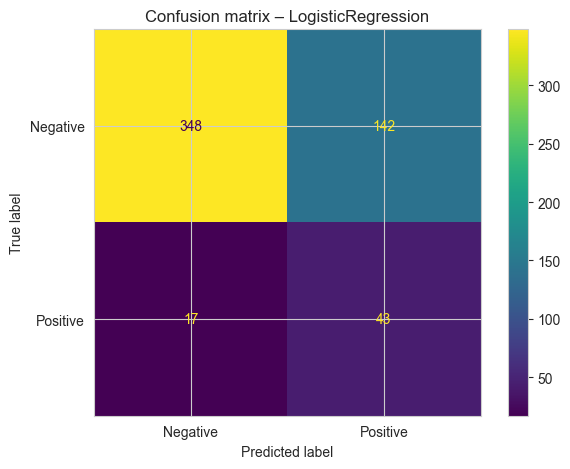

In [137]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# ------------------------------------------------------------------
# Loop once per model
# ------------------------------------------------------------------
for r in results:
    cm      = r["confusion_matrix"]          
    model   = r["model"]                    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Negative", "Positive"])
    disp.plot(values_format="d")             

    plt.title(f"Confusion matrix – {model}")
    plt.tight_layout()
    plt.show()


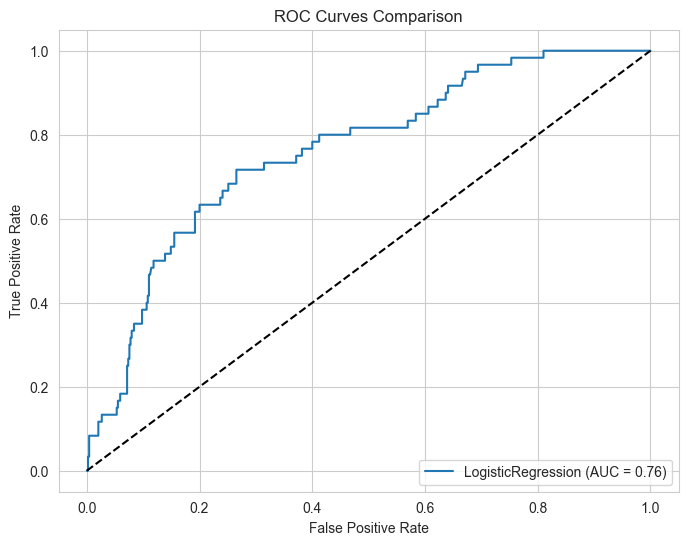

In [138]:
# Plot ROC curve
plt.figure(figsize=(8,6))
for r in results:
    # Use best estimator to get ROC values
    name = r['model']
    probas = search.best_estimator_.named_steps['clf'].predict_proba(
        search.best_estimator_.named_steps['preproc'].transform(X_test)
    )[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probas)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {r['roc_auc']:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.show()

The script spends most of its effort on three key tasks that deliver the bulk of its value:
Prepare and enrich the data – it reads in the master CSV, converts dates, builds a unique customer ID, computes total and discounted premiums, derives age/car‐age and urbanicity features, and standardizes numeric columns.
Fill in missing values – numeric fields are imputed with brand‐level averages, categorical ones with brand‐level modes, and income is backfilled first by ZIP4‐level mode then by province‐level mode.
Segment and predict – it clusters customers (and separately brands) using PCA + KMeans, evaluates cluster quality, then trains a supervised model (with SMOTE and hyperparameter search) to predict conversion. All transformers and models are finally saved for reuse.

The extensive comments are provided in the report and the presentation.